In [1]:
from PIL import Image, ImageDraw, ImageFont
from transformers import LayoutLMv2Processor, LayoutLMv2ImageProcessor
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from pathlib import Path
import json
from collections import defaultdict
import pandas as pd
import torch

## General exploration of the data structures and various functions from huggingface

In [2]:
img_path = Path("../datasets/custom_youtube/white_bg/export/2024-03-13-20-58/images/613b5c04-yt_big_1.png")
image = Image.open(
        img_path
).convert("RGB")

width, height = image.size

In [3]:
#processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2ImageProcessor.from_pretrained("microsoft/layoutlmv2-base-uncased")

In [4]:
encoding = processor(
    image, return_tensors="pt"
)  # you can also add all tokenizer parameters here such as padding, truncation
print(encoding.keys())

dict_keys(['pixel_values', 'words', 'boxes'])


In [5]:
encoding.words

[['9',
  '@Jonathandelarosa1199',
  '1',
  'month',
  'ago',
  "There's",
  'something',
  'adorable',
  'about',
  'little',
  'Sam',
  'call',
  'ty',
  'DB',
  'reply',
  '1g',
  'Matt',
  'and',
  'Marisha,',
  'Mr.',
  'Matt',
  'and',
  'Ms.',
  'Marisha.',
  '*',
  '4replies',
  'e',
  '@SLorraineE',
  '1',
  'month',
  'ago',
  'Yes!!!',
  'So',
  'cute!',
  'Oe',
  'GB',
  'Reply',
  '@',
  '@DragonElixion',
  '1',
  'month',
  'ago',
  'Look...',
  'l',
  'thought',
  'the',
  'same',
  'thing',
  'too...',
  'then',
  '|',
  'remembered',
  'that',
  'a',
  'few',
  'episodes',
  'back',
  'Marisha',
  'suggested',
  'it',
  'was',
  'the',
  'start',
  'of',
  'their',
  'throuple...',
  'and',
  'now',
  'I',
  "don't",
  'know',
  'how',
  'to',
  'feel.',
  'oe',
  'BF',
  'Reply',
  '6',
  '@Shakeandbake1990',
  '1',
  'month',
  'ago',
  'Itwas',
  'adorable',
  'OP',
  'Reply',
  '2',
  '@Grifter-2005',
  '1',
  'month',
  'ago',
  'It',
  'was',
  'cute',
  'until',


#### LayoutMLv2 uses different normalization of bboxes than label studio

In [6]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def unnormalize_ls_box(bbox, width, height):
     return [
         width * (bbox[0] / 100),
         height * (bbox[1] / 100),
         width * (bbox[2] / 100),
         height * (bbox[3] / 100),
     ]

In [7]:
# def fix_y_coords(box):
#   return [box[0], box[3], box[2], box[1]]

# def fix_x_coords(box):
#   return [box[2], box[1], box[0], box[3]]

def draw_boxes(img: Image, boxes, norm = True):
  draw = ImageDraw.Draw(img)

  width, height = img.size

  for box in boxes:
    print(box)
    # if norm:
    box = unnormalize_ls_box(box, width, height)
    draw.rectangle(box, outline="blue", width=2)

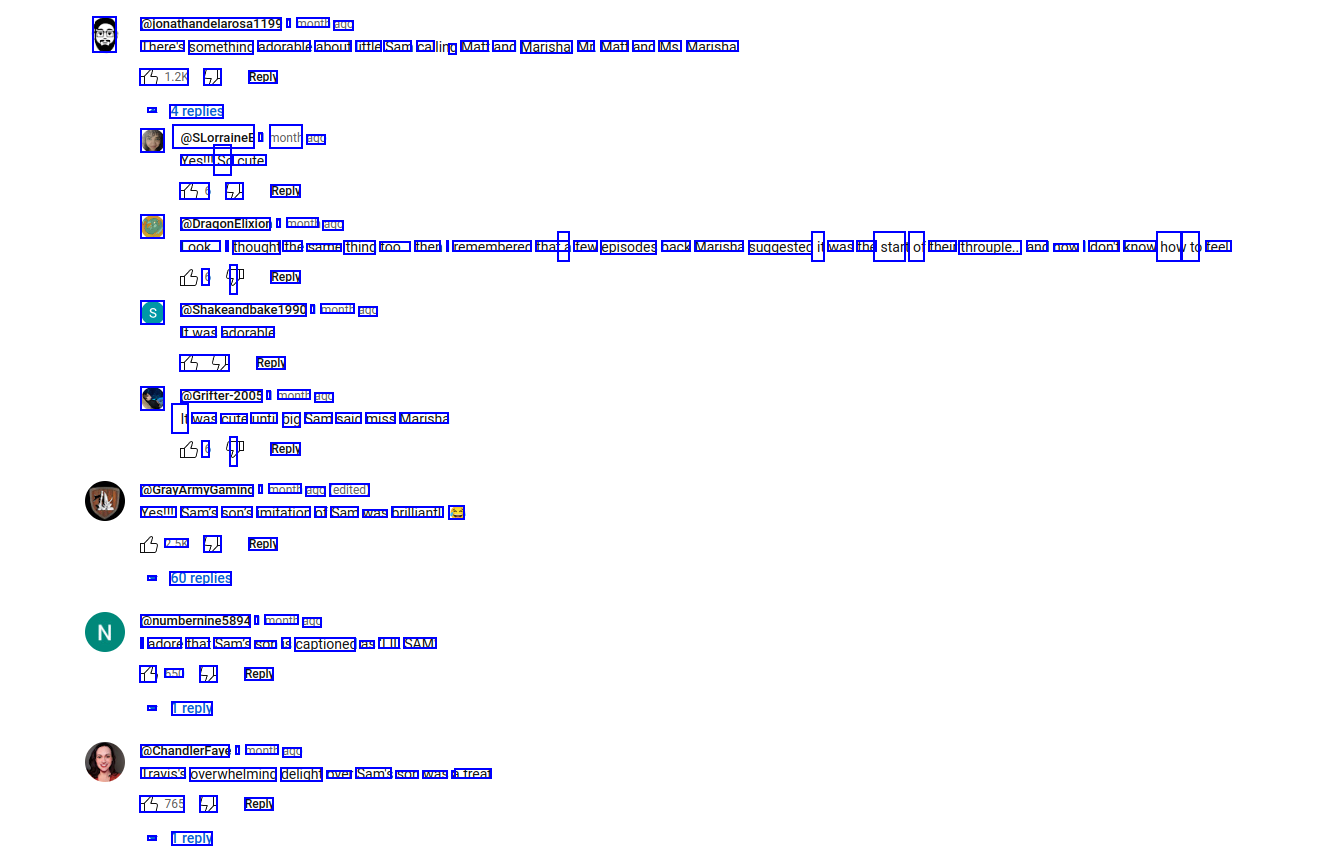

In [8]:
draw = ImageDraw.Draw(image)

# for box in encoding.bbox[0]:
for box in encoding.boxes[0]:
  # actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline="blue", width=2)
  # draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)


# box = unnormalize_box(encoding.boxes[0][0], width, height)
# draw.rectangle(box, outline="green", width=2)

image

### Dataset paths

In [9]:
COCO_PATH = Path("../datasets/custom_youtube/white_bg/export/2024-03-13-20-58") # using just for images, since their names are "mangled" by lable studio
ANNOT_PATH = Path("../datasets/custom_youtube/white_bg/export/min-project-4-at-2024-03-13-19-53-af410d9e.json") # these are the actual annotations

In [10]:
# NOTE: can't get coco export from label studio to work
# Don't need to run this
return # OK to error here
def prepare_coco_annotations(path: Path):

  d = defaultdict(lambda: { "bbox": [], "image": None })

  with open(path/"result.json", "r") as f:
    results = json.load(f)

    # print(results["categories"])
    print(list(filter(lambda a: a["image_id"] == 0, results["annotations"])))
    # print(results.keys())

  for annot in results["annotations"]:
    d[annot["image_id"]]["bbox"].append({ "box": annot["bbox"], "class_id": annot["category_id"] })

  for img in results["images"]:
    d[img["id"]]["image"] = img["file_name"].split("/")[1]

  # print(d)

  classes = {}
  for cat in results["categories"]:
    classes[cat["id"]] = cat["name"]

  return (d, classes)


# annots, id2cls_dict = prepare_coco_annotations(ANNOT_PATH)

SyntaxError: 'return' outside function (565011241.py, line 3)

Get the label studio export into some usable shape

In [12]:
def make_bbox(rect):
  return [rect["x"], rect["y"], rect["x"] + rect["width"], rect["y"] + rect["height"]]


cls2id = {
  "O": 0,
  "Body": 1,
  "Author": 2,
  "Date": 3
}
labels = list(cls2id.keys())

def prepare_annotations(path: Path):


  d = defaultdict(lambda: { "bbox": [], "image": None })

  with open(path, "r") as f:
    results = json.load(f)
    print(results)
    print(results[0].keys())

  for annot in results:
    for b in annot["label"]:
      d[annot["id"]]["bbox"].append({ "box": make_bbox(b), "class_id": cls2id[b["rectanglelabels"][0]] })
    d[annot["id"]]["image"] = annot["image"].split("/")[-1]

  # for img in results["images"]:
  #   d[img["id"]]["image"] = img["file_name"].split("/")[1]

  # print(d)

  classes = {}
  for n,i in cls2id.items():
    classes[i] = n

  return (d, classes)


annots, id2cls_dict = prepare_annotations(ANNOT_PATH)

[{'image': '/data/upload/4/613b5c04-yt_big_1.png', 'id': 8, 'label': [{'x': 10.387323943661972, 'y': 4.106606854240195, 'width': 45.86267605633803, 'height': 2.8746247979681367, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.380281690140844, 'y': 17.384635682950158, 'width': 8.18661971830986, 'height': 3.148398588250817, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.29225352112676, 'y': 27.651152818550646, 'width': 80.36971830985917, 'height': 2.60085100768546, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.380281690140844, 'y': 37.91766995415114, 'width': 7.922535211267604, 'height': 2.4639641125441187, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.556338028169016, 'y': 47.773526404327605, 'width': 20.686619718309856, 'height': 2.6008510076854563, 'rotation': 0, 'rec

In [13]:
# TODO: i don't think this works properly right now
def calculate_iou(box1, box2):
    x0_inter = max(box1[0], box2[0])
    y0_inter = max(box1[1], box2[1])
    x1_inter = min(box1[2], box2[2])
    y1_inter = min(box1[3], box2[3])
    
    if x1_inter < x0_inter or y1_inter < y0_inter:
        return 0.0
    
    intersection_area = (x1_inter - x0_inter) * (y1_inter - y0_inter)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area
    
    return iou

### See how OCR bboxes and manual label overlap

[[10.387323943661972, 4.106606854240195, 56.25, 6.981231652208332], [13.380281690140844, 17.384635682950158, 21.566901408450704, 20.533034271200975], [13.29225352112676, 27.651152818550646, 93.66197183098592, 30.252003826236106], [13.380281690140844, 37.91766995415114, 21.30281690140845, 40.381634066695256], [13.556338028169016, 47.773526404327605, 34.24295774647887, 50.37437741201306], [10.387323943661972, 58.99825180591747, 35.91549295774648, 61.73598970874426], [10.299295774647888, 74.1926971666062, 33.274647887323944, 76.79354817429164], [10.387323943661972, 89.38714252729491, 37.852112676056336, 91.85110663983903], [21.390845070422536, 1.9164165319787578, 26.76056338028169, 3.559059273674836], [19.630281690140844, 15.331332255830063, 24.911971830985916, 16.97397499752614], [20.68661971830986, 25.32407560114787, 26.056338028169012, 27.10360523798529], [23.41549295774648, 35.59059273674836, 28.69718309859155, 37.37012237358577], [20.158450704225352, 45.17267539664215, 25.17605633802

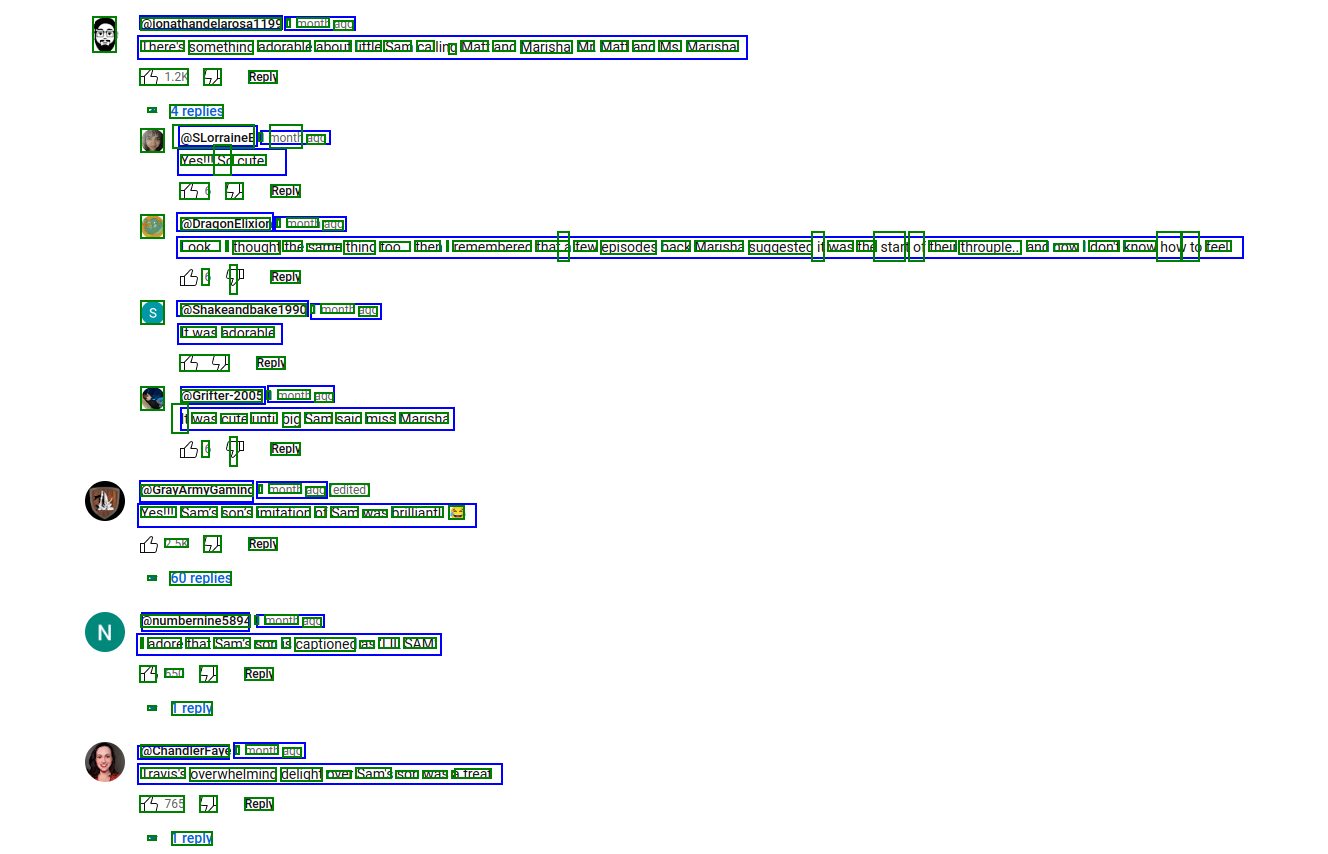

In [14]:
img = Image.open(COCO_PATH / "images" / annots[8]["image"]).convert("RGB")


boxes = list(map(lambda b: b["box"], annots[8]["bbox"]))
print(list(boxes))

draw_boxes(img, boxes, False)

draw = ImageDraw.Draw(img)

for box in encoding.boxes[0]:
  # actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline="green", width=2)

img

### Mark OCR bboxes with corresponding labels (based on manual label "blocks" from label studio)

In [15]:

anot = annots[8]
img = Image.open(COCO_PATH / "images" / anot["image"]).convert("RGB")


# boxes = list(map(lambda b: b["box"], anot["bbox"]))
# print(list(boxes))

def classify_bboxes(img: Image, encoding, anot):

  width, height = img.size

  ner_tags  = []
  for i,box in enumerate(encoding.boxes[0]):
    # print(block)
    ner_tags.append(0)

    for block in anot["bbox"]:
      iou = calculate_iou(unnormalize_ls_box(block["box"], width, height), unnormalize_box(box, width, height)) # TODO: fix iou -- don't think it works
      # print(iou)

      if iou > 0: # there is some overlap -- mark it with that label (iou doesn't seem to work properly...)
        ner_tags[i] = block["class_id"]


  print(ner_tags)
  return ner_tags

In [16]:
draw = ImageDraw.Draw(img)

id2color = {
  0: "black",
  1: "green",
  2: "blue",
  3: "yellow"
}

# for i,box in enumerate(encoding.boxes[0]):
#   # actual_label = iob_to_label(id2label[label]).lower()
#   box = unnormalize_box(box, width, height)
#   draw.rectangle(box, outline=id2color[ner_tags[i]], width=2)

# img

## Create dataset

In [17]:
from torch.utils.data import DataLoader
from datasets import Dataset

def make_dataset(annots):
  words = []
  boxes = []
  images = []
  word_labels = []

  processor = LayoutLMv2ImageProcessor.from_pretrained("microsoft/layoutlmv2-base-uncased")

  for id,val in annots.items():
    # val["bbox"] # list
    # val["image"] # base name

    image = Image.open(COCO_PATH / "images" / val["image"]).convert("RGB")

    # TODO: could this be done for all images at one time?
    encoding = processor(image, return_tensors="pt")  # you can also add all tokenizer parameters here such as padding, truncation
    
    ner_tags = classify_bboxes(image, encoding, val)

    words.append(encoding.words[0])
    boxes.append(encoding.boxes[0])
    images.append(val["image"])
    word_labels.append(ner_tags)

    print(val["image"])




  ds = Dataset.from_pandas(pd.DataFrame({ 
    "image": images,
    "words": words,
    "boxes": boxes,
    "word_labels": word_labels,
    "id": id
  }))

  return ds

# make_dataset(annots)

In [18]:
annots, id2cls_dict = prepare_annotations(ANNOT_PATH)

ds = make_dataset(annots)

ds



[{'image': '/data/upload/4/613b5c04-yt_big_1.png', 'id': 8, 'label': [{'x': 10.387323943661972, 'y': 4.106606854240195, 'width': 45.86267605633803, 'height': 2.8746247979681367, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.380281690140844, 'y': 17.384635682950158, 'width': 8.18661971830986, 'height': 3.148398588250817, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.29225352112676, 'y': 27.651152818550646, 'width': 80.36971830985917, 'height': 2.60085100768546, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.380281690140844, 'y': 37.91766995415114, 'width': 7.922535211267604, 'height': 2.4639641125441187, 'rotation': 0, 'rectanglelabels': ['Body'], 'original_width': 1328, 'original_height': 854}, {'x': 13.556338028169016, 'y': 47.773526404327605, 'width': 20.686619718309856, 'height': 2.6008510076854563, 'rotation': 0, 'rec

Dataset({
    features: ['image', 'words', 'boxes', 'word_labels', 'id'],
    num_rows: 10
})

In [19]:

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

# we need to define custom features
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=labels)),
})

# def preprocess_data(boxes, words, ner_tags, img_path):
def preprocess_data(examples):
  print("ex:", (examples["words"]))
  image = [Image.open(COCO_PATH / "images" / path).convert("RGB") for path in examples["image"]]
  # image = Image.open(COCO_PATH / "images" / examples["image"]).convert("RGB")
  # words = words
  # boxes = boxes
  # word_labels = ner_tags
  
  encoded_inputs = processor(image, examples["words"], boxes=examples["boxes"], word_labels=examples["word_labels"],
                             padding="max_length", truncation=True)
  
  return encoded_inputs

# train_dataset = datasets['train'].map(preprocess_data, batched=True, remove_columns=datasets['train'].column_names,
#                                       features=features)


train_dataset = ds.map(preprocess_data, batched=True, features=features, batch_size=5, remove_columns=ds.column_names)

# sample = preprocess_data(encoding.boxes[0], encoding.words[0], ner_tags, anot["image"])

Map:  50%|█████     | 5/10 [00:00<00:00, 28.23 examples/s]

ex: [['9', '@Jonathandelarosa1199', '1', 'month', 'ago', "There's", 'something', 'adorable', 'about', 'little', 'Sam', 'call', 'ty', 'DB', 'reply', '1g', 'Matt', 'and', 'Marisha,', 'Mr.', 'Matt', 'and', 'Ms.', 'Marisha.', '*', '4replies', 'e', '@SLorraineE', '1', 'month', 'ago', 'Yes!!!', 'So', 'cute!', 'Oe', 'GB', 'Reply', '@', '@DragonElixion', '1', 'month', 'ago', 'Look...', 'l', 'thought', 'the', 'same', 'thing', 'too...', 'then', '|', 'remembered', 'that', 'a', 'few', 'episodes', 'back', 'Marisha', 'suggested', 'it', 'was', 'the', 'start', 'of', 'their', 'throuple...', 'and', 'now', 'I', "don't", 'know', 'how', 'to', 'feel.', 'oe', 'BF', 'Reply', '6', '@Shakeandbake1990', '1', 'month', 'ago', 'Itwas', 'adorable', 'OP', 'Reply', '2', '@Grifter-2005', '1', 'month', 'ago', 'It', 'was', 'cute', 'until', 'big', 'Sam', 'said', 'miss', 'Marisha', 'oe', 'BF', 'Reply', '@GrayArmyGaming', '1', 'month', 'ago', '(edited)', 'Yes!ll!', "Sam's", "son's", 'imitation', 'of', 'Sam', 'was', 'brillia

Map: 100%|██████████| 10/10 [00:00<00:00, 33.63 examples/s]


### Verify sample

In [20]:
print(processor.tokenizer.decode(train_dataset[0]['input_ids']))
print(train_dataset[0]['labels'])

train_dataset

[CLS] 9 @ jonathandelarosa1199 1 month ago there's something adorable about little sam call ty db reply 1g matt and marisha, mr. matt and ms. marisha. * 4replies e @ slorrainee 1 month ago yes!!! so cute! oe gb reply @ @ dragonelixion 1 month ago look... l thought the same thing too... then | remembered that a few episodes back marisha suggested it was the start of their throuple... and now i don't know how to feel. oe bf reply 6 @ shakeandbake1990 1 month ago itwas adorable op reply 2 @ grifter - 2005 1 month ago it was cute until big sam said miss marisha oe bf reply @ grayarmygaming 1 month ago ( edited ) yes! ll! sam's son's imitation of sam was brilliant! & 25 % gd reply ~ 60replies @ numbernine5894 1 month ago | adore that sam's son is captioned as ‘ lil sam ’ 1 550 gb reply ~ reply @ chandlerfaye 1 month ago travis's overwhelming delight over sam's son was a treat 75 dd reply + treply [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'],
    num_rows: 10
})

In [21]:
train_dataset.set_format(type="torch")

In [22]:
train_dataset.features.keys()

dict_keys(['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'])

create loader

In [23]:
  
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=2)

In [24]:
# look at a batch

batch = next(iter(train_dataloader))

for k,v in batch.items():
  print(k, v.shape)

image torch.Size([2, 3, 224, 224])
input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
token_type_ids torch.Size([2, 512])
bbox torch.Size([2, 512, 4])
labels torch.Size([2, 512])


### Train the model

In [38]:
# copied from Fine_tuning_LayoutLMv2ForToeknClassification_on_FUNSD_using_HuggingFace_Trainer.ipynb
from transformers import LayoutLMv2ForTokenClassification, TrainingArguments, Trainer
from datasets import load_metric
import numpy as np


torch.cuda.empty_cache()

model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                                      num_labels=len(cls2id))

# Set id2label and label2id 
model.config.id2label = id2cls_dict
model.config.label2id = cls2id

# Metrics
metric = load_metric("seqeval")
return_entity_level_metrics = True

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2cls_dict[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2cls_dict[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

class CommentTrainer(Trainer):
    def get_train_dataloader(self):
      return train_dataloader

    def get_test_dataloader(self, test_dataset):
    #   return test_dataloader
      return train_dataloader

# torch.cuda.set_device(0)

args = TrainingArguments(
    output_dir="layoutlmv2-finetuned-yt-v2", # name of directory to store the checkpoints
    max_steps=1000, # we train for a maximum of 1,000 batches
    warmup_ratio=0.1, # we warmup a bit
    fp16=True, # we use mixed precision (less memory consumption)
    push_to_hub=False, 
)

# print(args.device)

# model = model.to(args.device)

# Initialize our Trainer
trainer = CommentTrainer(
    model=model,
    args=args,
    compute_metrics=compute_metrics,
)

torch.cuda.empty_cache()

  2%|▎         | 25/1000 [05:30<3:34:35, 13.21s/it]
Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/filip/fit/mit/s2/knn/project/venv/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/filip/fit/mit/s2/knn/project/venv/lib/python3.10/site-packages/accelerate/

# Actual training happens here

In [39]:
trainer.train()

 50%|█████     | 500/1000 [08:45<08:44,  1.05s/it]

{'loss': 0.2637, 'grad_norm': 0.25355440378189087, 'learning_rate': 2.7833333333333333e-05, 'epoch': 100.0}


100%|██████████| 1000/1000 [17:50<00:00,  1.09s/it]

{'loss': 0.0614, 'grad_norm': 0.13249503076076508, 'learning_rate': 1.1111111111111112e-07, 'epoch': 200.0}


100%|██████████| 1000/1000 [17:58<00:00,  1.08s/it]

{'train_runtime': 1078.008, 'train_samples_per_second': 7.421, 'train_steps_per_second': 0.928, 'train_loss': 0.16257098960876465, 'epoch': 200.0}


TrainOutput(global_step=1000, training_loss=0.16257098960876465, metrics={'train_runtime': 1078.008, 'train_samples_per_second': 7.421, 'train_steps_per_second': 0.928, 'train_loss': 0.16257098960876465, 'epoch': 200.0})

### Should use a test_dataset, I don't have one right now

In [40]:

predictions, labels, metrics = trainer.predict(train_dataset)

100%|██████████| 5/5 [00:00<00:00,  5.75it/s]/home/filip/fit/mit/s2/knn/project/venv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Author seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/filip/fit/mit/s2/knn/project/venv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Date seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/filip/fit/mit/s2/knn/project/venv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Body seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


In [41]:
print(metrics)

{'test_loss': 0.047826625406742096, 'test_ate_precision': 1.0, 'test_ate_recall': 0.98, 'test_ate_f1': 0.98989898989899, 'test_ate_number': 50, 'test_ody_precision': 0.9983766233766234, 'test_ody_recall': 1.0, 'test_ody_f1': 0.9991876523151909, 'test_ody_number': 1230, 'test_uthor_precision': 1.0, 'test_uthor_recall': 0.9814814814814815, 'test_uthor_f1': 0.9906542056074767, 'test_uthor_number': 54, 'test_overall_precision': 0.9985007496251874, 'test_overall_recall': 0.9985007496251874, 'test_overall_f1': 0.9985007496251874, 'test_overall_accuracy': 0.9987908101571947, 'test_runtime': 1.1007, 'test_samples_per_second': 9.085, 'test_steps_per_second': 1.817}


In [42]:
print(predictions)
print(labels)

[[[ 0.42578125  1.0712891  -0.15490723 -1.9033203 ]
  [-0.66015625 -0.7055664   2.4042969  -0.6376953 ]
  [-0.6303711  -0.68603516  2.3886719  -0.6845703 ]
  ...
  [ 2.84375    -0.8911133  -0.8125     -0.86865234]
  [ 2.5878906  -0.88134766 -0.50390625 -0.9555664 ]
  [ 2.8476562  -0.88623047 -0.8286133  -0.859375  ]]

 [[ 1.2197266   0.4025879  -0.3527832  -1.5693359 ]
  [-0.69677734 -0.67285156  2.4023438  -0.6245117 ]
  [-0.70458984 -0.6611328   2.390625   -0.6254883 ]
  ...
  [ 2.7363281  -0.82470703 -0.70654297 -1.0097656 ]
  [ 2.2363281  -0.5649414  -0.5966797  -1.0605469 ]
  [ 2.828125   -0.8330078  -0.8066406  -0.96972656]]

 [[ 0.21398926  1.7763672  -1.0869141  -1.9003906 ]
  [ 2.8554688  -0.9121094  -0.7739258  -0.88720703]
  [ 2.8535156  -0.8886719  -0.79833984 -0.88916016]
  ...
  [ 2.8457031  -0.89990234 -0.7763672  -0.8964844 ]
  [ 2.8261719  -0.90283203 -0.73876953 -0.9135742 ]
  [ 2.8476562  -0.88671875 -0.80615234 -0.88378906]]

 ...

 [[-0.7705078   2.4550781  -1.2001

## Inference using a single image

In [43]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("./layoutlmv2-finetuned-yt-v2/checkpoint-1000")

In [44]:

# NOTE: custom text and bboxes can be suplied, see parameter: use_ocr=False
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")

In [45]:
# img_path = Path("../datasets/custom_youtube/white_bg/export/2024-03-13-20-58/images/613b5c04-yt_big_1.png")
img_path = Path("../datasets/custom_sz/sz_1.png")
image = Image.open(
        img_path
).convert("RGB")

width, height = image.size

In [53]:
encoding = processor(
    image, return_tensors="pt", return_offsets_mapping=True
)  # you can also add all tokenizer parameters here such as padding, truncation
print(encoding.keys())

offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())
# encoding.to("cuda") # can move to GPU -- have to move both encoding and the model below

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'bbox', 'image'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])


{'input_ids': tensor([[  101,  1054,  2140, 12436, 20464, 11431,  7570, 16555,  1090,  3653,
          2094,  2539,  7570, 18979,  4328,  1024,  1047,  8180,  2638,  1012,
         17712,  6525,  2102, 15333,  2000,  1058,  6806,  2094,  2638, 15419,
          2079,  1047, 21273,  4890,  2818,  2079,  2497,  1012,  1058, 26927,
         15455,  2063, 11748,  4801, 11265,  5092, 28774, 21239, 12274, 13007,
          7140, 15315, 11474,  2638, 26261,  4890, 15488, 28228,  2278,   999,
          1037, 11265, 10875, 17884, 11876,  2072, 23068,  3490,  4779,  1012,
          1012,  1012,  9743,  4817,  3520, 18153,  7959, 24703,  2063, 13007,
          4492,  2100,  1055, 24098, 18153,  3367,  5737,  2213, 27178,  6777,
         18940, 17994,  4013, 23809, 19300,  2213,  1010, 15669,  1058,  2061,
         13210,  2015, 15460,  2102, 15333,  2000, 15544,  5831,  3683,  1012,
         14855, 26029, 21590, 14855,  3683,  9808, 13181,  2615, 15333,  3520,
         18153,  7959, 24703,  2063,  

In [54]:
# model = model.to("cuda")
with torch.no_grad():
  outputs = model(**encoding)

In [56]:
print(outputs.logits.shape)

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2cls_dict[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

print(true_predictions)
print(true_boxes)    

torch.Size([1, 474, 4])
['Body', 'O', 'Author', 'Author', 'Date', 'Date', 'Date', 'O', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Author', 'O', 'O', 'O', 'O', 'Author', 'Author', 'O', 'Date', 'Date', 'Date', 'O', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'O', 'O', 'O', 'O', 'Author', 'O', 'O', 'O', 'Author', 'Author', 'O', 'Date', 'Date', 'Date', 'O', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'Body', 'O', 'Author', 'Author', 'O', 'Date', 'Dat

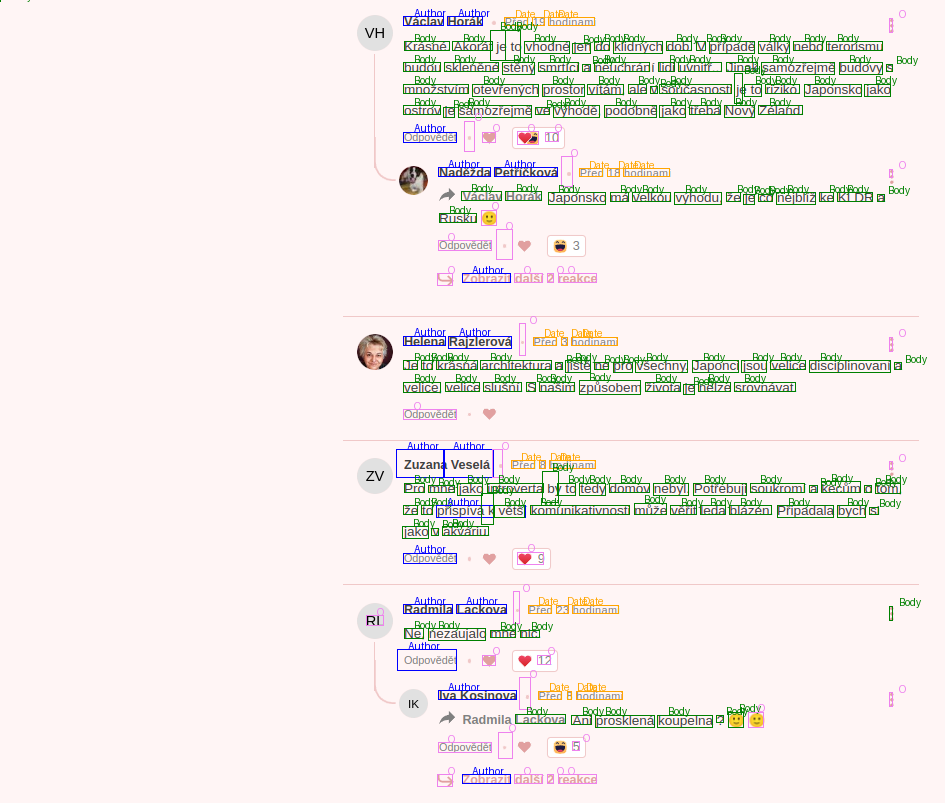

In [57]:
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

# def iob_to_label(label):
#     label = label[2:]
#     if not label:
#       return 'other'
#     return label

label2color = {'Author':'blue', 'Body':'green', 'Date':'orange', 'O':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = prediction # iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)

image